In [1]:
import os
import gzip
import numpy as np
import matplotlib.pyplot as plt

import umap
import matplotlib.collections
from scipy.stats.stats import iqr
from scipy.stats import boxcox


import statsmodels.api as sm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import factorial

import scipy.stats as ss
import scipy.optimize as so

import abmethods_cd as ab

In [2]:
path = {'in_folder'          : '/home/cyrille/Desktop/Cy_PostDoc/Projects/AML_DABseq/data', 
        'out_folder'         : '/home/cyrille/Desktop/Cy_PostDoc/Projects/AML_DABseq/data', 
        'variants_file_path' : '/home/cyrille/Desktop/Cy_PostDoc/Projects/AML_DABseq/data/patient_577.variants.tsv.gz',
        'genotypes_path'     : '/home/cyrille/Desktop/Cy_PostDoc/Projects/AML_DABseq/data/patient_577.genotypes.hdf5'}

labels = {'abseq13': 'diagnosis',
          'abseq17': 'relapse_1',
          'abseq15': 'relapse_2',
          'abseq16': 'remission'}

ab_codes = ['CD10', 'CD117', 'CD11b', 'CD123', 'CD13', 
            'CD14', 'CD15', 'CD16', 'CD19','CD22', 'CD3', 
            'CD30', 'CD33', 'CD34', 'CD38', 'CD4', 'CD45', 
            'CD5', 'CD56','CD64', 'CD7', 'CD71', 'HLA-DR', 'IgG1']


In [3]:
pat577_exps = ['abseq13','abseq17','abseq15','abseq16']
pat577 = ab.Patient.merge_experiments(exp_nr_list=pat577_exps,
                                      data_path=path,
                                      antibodies=ab_codes,
                                      min_abs=100,
                                      max_IgG1=5,
                                      covariables=['IgG1','ab_raw', 'ab_umi', 'amplicon'],
                                      components=3,
                                      offset=False,
                                      use_andat=True)

In [ ]:
pat577.load_genotypes(suffix='patient577', from_loom=True)

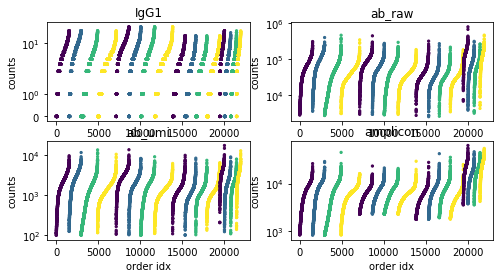

In [6]:
qc_data = np.array(pat577.pat_andat_raw.obs[['IgG1','ab_raw', 'ab_umi', 'amplicon', 'batch', 'experiment']])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(8, 4))

ind = np.lexsort((pat577.pat_andat_raw.obs['IgG1'],pat577.pat_andat_raw.obs['batch'],pat577.pat_andat_raw.obs['experiment']))
ax1.set_title('IgG1')
ax1.set_ylabel('counts')
ax1.set_xlabel('order idx')
ax1.scatter(np.arange(len(ind)), qc_data[ind][:,0], c=qc_data[ind][:,4],  s=5, cmap='viridis')
ax1.set_yscale('symlog')

ind = np.lexsort((pat577.pat_andat_raw.obs['ab_raw'],pat577.pat_andat_raw.obs['batch'],pat577.pat_andat_raw.obs['experiment']))
ax2.set_title('ab_raw')
ax2.set_ylabel('counts')
ax2.set_xlabel('order idx')
ax2.scatter(np.arange(len(ind)), qc_data[ind][:,1], c=qc_data[ind][:,4],  s=5, cmap='viridis')
ax2.set_yscale('symlog')

ind = np.lexsort((pat577.pat_andat_raw.obs['ab_umi'],pat577.pat_andat_raw.obs['batch'],pat577.pat_andat_raw.obs['experiment']))
ax3.set_title('ab_umi')
ax3.set_ylabel('counts')
ax3.set_xlabel('order idx')
ax3.scatter(np.arange(len(ind)), qc_data[ind][:,2], c=qc_data[ind][:,4],  s=5, cmap='viridis')
ax3.set_yscale('symlog')

ind = np.lexsort((pat577.pat_andat_raw.obs['amplicon'],pat577.pat_andat_raw.obs['batch'],pat577.pat_andat_raw.obs['experiment']))
ax4.set_title('amplicon')
ax4.set_ylabel('counts')
ax4.set_xlabel('order idx')
ax4.scatter(np.arange(len(ind)), qc_data[ind][:,3], c=qc_data[ind][:,4],  s=5, cmap='viridis')
ax4.set_yscale('symlog')
#plt.savefig('.png', dpi=600)
plt.show()

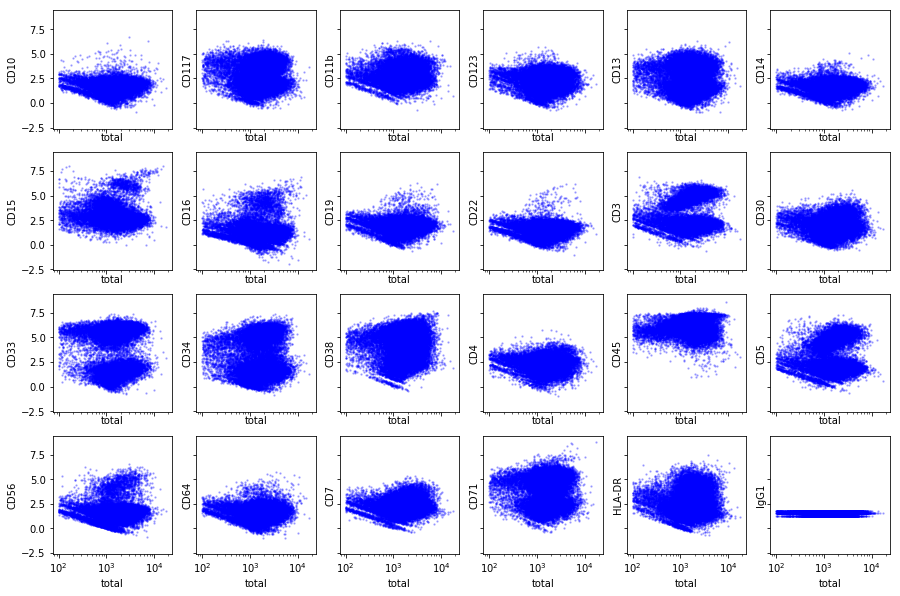

In [7]:
fig, ax = plt.subplots(4,6, figsize=(15, 10), sharex=True, sharey=True)
for i in range(24):
    ax[int(i/6),i%6].set_ylabel(pat577.ab_names[i])
    ax[int(i/6),i%6].set_xlabel('total')
    ax[int(i/6),i%6].scatter(pat577.pat_andat_raw.obs['ab_umi'], pat577.pat_andat.X[:,i], c='b', alpha = 0.25,  s=2, cmap='viridis')
    #ax[int(i/6),i%6].set_yscale('symlog')
    ax[int(i/6),i%6].set_xscale('log')
plt.show()

In [8]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(pat577.pat_andat.X[:,:-1])
embedding.shape

/home/cyrille/.local/lib/python3.6/site-packages/umap/rp_tree.py:450: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "make_euclidean_tree" failed type inference due to: Cannot unify RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none) and RandomProjectionTreeNode(none, bool, array(float32, 1d, C), float64, RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none), RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none)) for '$14.16', defined at /home/cyrille/.local/lib/python3.6/site-packages/umap/rp_tree.py (457)

File "../../../../.local/lib/python3.6/site-packages/umap/rp_tree.py", line 457:
def make_euclidean_tree(data, indices, rng_state, leaf_size=30):
    <source elided>

        left_node = make_euclidean_tree(data, left_indices, rng_state, leaf_size)
        ^

[1] During: resolving callee type: recursive(type(CPUDispatcher(<function make_euclidean_tree at 0x7f2477

(21964, 2)

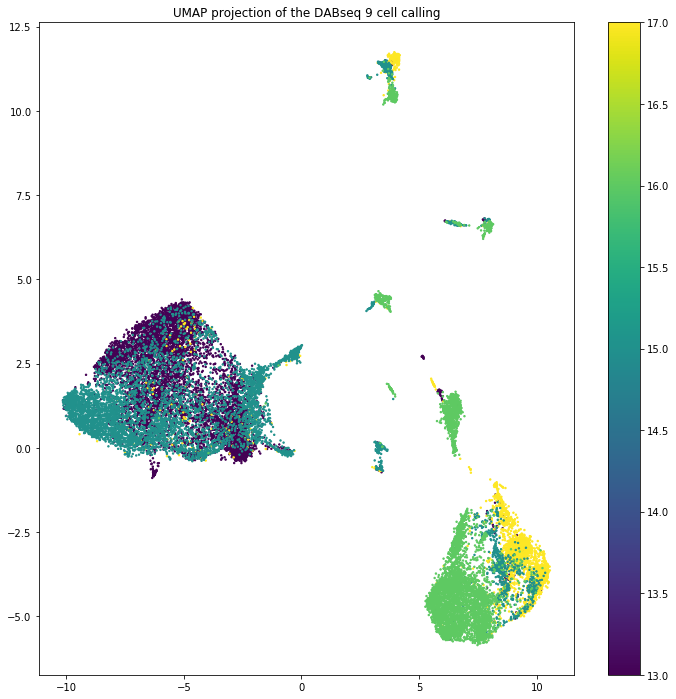

In [10]:
fig, ax = plt.subplots(1,1,figsize=(12,12))
#np.log(datmat[:,pat577.ab_map['IgG1']]+1)
scatter = ax.scatter(embedding[:, 0], embedding[:, 1], s=2, c=np.array(pat577.pat_andat.obs['experiment']).astype(int), cmap='viridis')
ax.set_title('UMAP projection of the DABseq 9 cell calling', fontsize=12)
plt.colorbar(scatter)
plt.savefig('PBMC_cellc_call.png')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


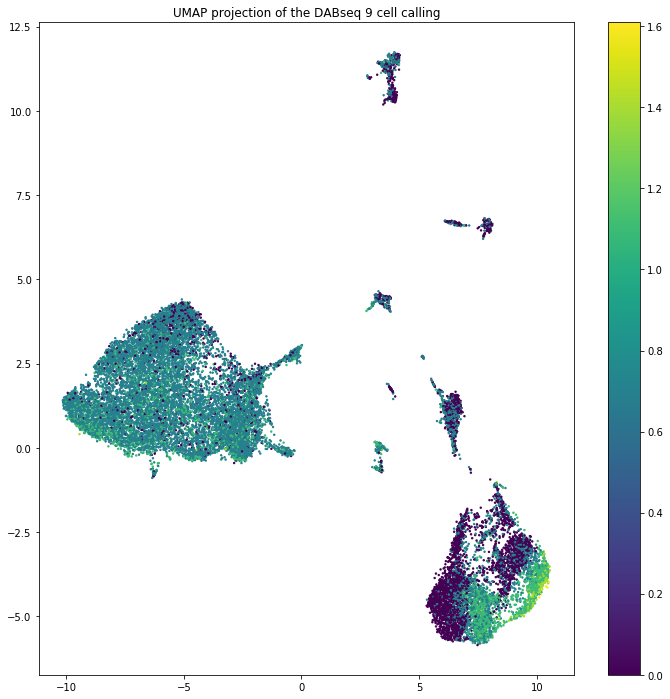

In [11]:
fig, ax = plt.subplots(1,1,figsize=(12,12))
ab_sel = np.log(np.array(pat577.pat_andat.X[:,pat577.ab_map['CD4']]).astype(int))
scatter = ax.scatter(embedding[:, 0], embedding[:, 1], s=2, c=ab_sel, cmap='viridis')
ax.set_title('UMAP projection of the DABseq 9 cell calling', fontsize=12)
plt.colorbar(scatter)
plt.savefig('PBMC_cellc_call.png')

In [ ]:
wt = np.sum(np.array(pat577.genotypes) == 0, axis=0)/21891.
het = np.sum(np.array(pat577.genotypes) == 1, axis=0)/21891.
alt = np.sum(np.array(pat577.genotypes) == 2, axis=0)/21891.
non = np.sum(np.array(pat577.genotypes) == 3, axis=0)/21891.


In [ ]:
idx = het>0.005

#plt.plot(wt[idx])
plt.plot(alt[idx])
plt.plot(het[idx])
#plt.plot(non[idx])
plt.show

In [ ]:

diff = np.diff(np.array([i.split(':')[2] for i in np.array(pat577.genotypes.columns)]).astype(int))
print(np.array([i.split(':')[2] for i in np.array(pat577.genotypes.columns)])[:-1][np.abs(diff)>1])
print(np.array([i.split(':')[2] for i in np.array(pat577.genotypes.columns)])[1:][np.abs(diff)>1])

plt.plot(diff[np.abs(diff)>1])

In [ ]:
def gene_performance(patient_object):
    self = patient_object
    diff = np.diff(np.array([i.split(':')[2] for i in np.array(self.genotypes.columns)]).astype(int))
    boundaries = np.arange(len(diff))[np.abs(diff>1)]
    return